In [ ]:
!pip install tensorflow matplotlib numpy

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

DATASET_DIR = "/content/drive/MyDrive/DATASET (1)/train"

IMG_SHAPE = IMG_SIZE + (3,)


In [46]:
train_dataset_raw = image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.1,
    subset="training",
    seed=SEED
)

validation_dataset_raw = image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.1,
    subset="validation",
    seed=SEED
)


Found 1248 files belonging to 3 classes.
Using 1124 files for training.
Found 1248 files belonging to 3 classes.
Using 124 files for validation.


In [47]:
class_names = train_dataset_raw.class_names
num_classes = len(class_names)

print("Detected classes:", class_names)
print("num_classes =", num_classes)


Detected classes: ['Aedes aegypti', 'Aedes albopictus', 'Culex quinquefasciatus']
num_classes = 3


In [49]:
train_dataset = train_dataset_raw
validation_dataset = validation_dataset_raw


In [50]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [55]:
def build_model(num_classes):

    # ---------------------
    # Base Model 1: VGG16
    # ---------------------
    vgg = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SHAPE
    )
    vgg.trainable = True
    for layer in vgg.layers[:-4]:
        layer.trainable = False

    # ---------------------
    # Base Model 2: MobileNetV2
    # ---------------------
    mobilenet = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SHAPE
    )
    mobilenet.trainable = False    # freeze all MobileNet layers

    # ---------------------
    # Input & Augmentation
    # ---------------------
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)

    # ---------------------
    # VGG16 Feature Extraction
    # ---------------------
    x_vgg = tf.keras.applications.vgg16.preprocess_input(x)
    x_vgg = vgg(x_vgg)
    x_vgg = layers.GlobalAveragePooling2D()(x_vgg)

    # ---------------------
    # MobileNet Feature Extraction
    # ---------------------
    x_mob = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x_mob = mobilenet(x_mob, training=False)
    x_mob = layers.GlobalAveragePooling2D()(x_mob)

    # ---------------------
    # Combine Features
    # ---------------------
    x = layers.Concatenate()([x_vgg, x_mob])
    x = layers.Dropout(0.1)(x)

    # ---------------------
    # Dense Head
    # ---------------------
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.1)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    # ---------------------
    # Compile
    # ---------------------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [56]:
model = build_model(num_classes)
model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 224, 224,  │          0 │ input_layer_20[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_15         │ (None, 224, 224)  │          0 │ sequential_2[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_16         │ (None, 224, 224)  │          0 │ sequential_2[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_17         │ (None, 224, 224)  │          0 │ sequential_2[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_9 (Stack)     │ (None, 224, 224,  │          0 │ get_item_15[0][0… │
│                     │ 3)                │            │ get_item_16[0][0… │
│                     │                   │            │ get_item_17[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_5       │ (None, 224, 224,  │          0 │ sequential_2[1][… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 224, 224,  │          0 │ stack_9[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_5          │ (None, 224, 224,  │          0 │ true_divide_5[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ subtract_5[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1792)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1792)      │          0 │ concatenate_5[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    459,008 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 17,432,451 (66.50 MB)

 Trainable params: 7,539,203 (28.76 MB)

 Non-trainable params: 9,893,248 (37.74 MB)

In [57]:
checkpoint_path = "/content/drive/MyDrive/vgg16_best.keras"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)


In [58]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/15
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.5219 - loss: 1.1566
Epoch 1: val_accuracy improved from -inf to 0.90323, saving model to /content/drive/MyDrive/vgg16_best.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5295 - loss: 1.1360 - val_accuracy: 0.9032 - val_loss: 0.2987
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.8744 - loss: 0.2984
Epoch 2: val_accuracy did not improve from 0.90323
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8749 - loss: 0.2976 - val_accuracy: 0.8952 - val_loss: 0.2434
Epoch 3/15
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.9166 - loss: 0.2276
Epoch 3: val_accuracy improved from 0.90323 to 0.95968, saving model to /content/drive/MyDrive/vgg16_best.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9170 - loss: 0.2262 - val_accuracy: 0.9597 - val_loss: 0.0986
Epoch 4/15
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.9400 - loss: 0.1515
Epoch 4: val_accuracy improved from 0.9

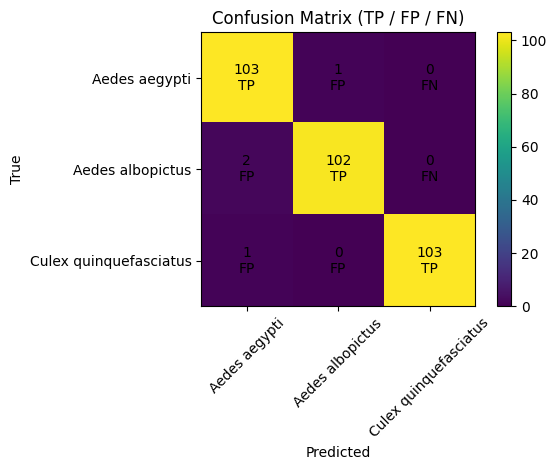

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

class_names = validation_dataset.class_names

cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (TP / FP / FN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

# Correct per-cell labeling
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]

        if i == j:
            label = "TP"
        else:
            label = "FP" if cm[:, j].sum() - cm[j, j] > 0 else "FN"

        plt.text(j, i, f"{value}\n{label}", ha="center", va="center")

plt.tight_layout()
plt.show()


In [75]:
for i, name in enumerate(class_names):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    print(f"\n{name}")
    print("TP:", TP)
    print("FP:", FP)
    print("FN:", FN)
    print("TN:", TN)



Aedes aegypti
TP: 103
FP: 3
FN: 1
TN: 205

Aedes albopictus
TP: 102
FP: 1
FN: 2
TN: 207

Culex quinquefasciatus
TP: 103
FP: 0
FN: 1
TN: 208


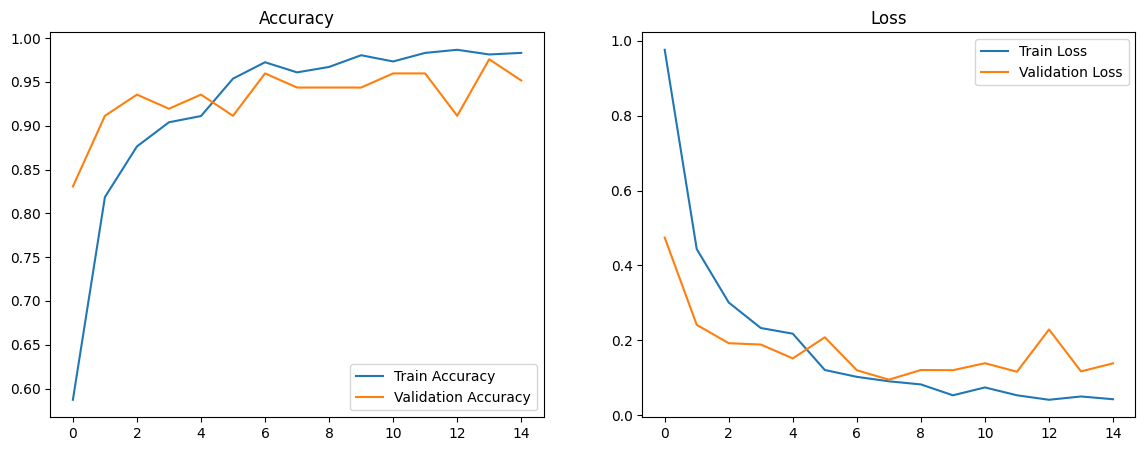

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()


In [62]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [23]:
TEST_DIR = "/content/drive/MyDrive/DATASET (1)/test"

test_dataset = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",    # so it matches your model
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False                # important for evaluation
)


Found 312 files belonging to 3 classes.


In [63]:
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 687ms/step - accuracy: 0.9910 - loss: 0.0306
Test Accuracy: 0.9871794581413269
Test Loss: 0.040568601340055466


In [73]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# -----------------------------
# 1. Get predictions
# -----------------------------
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = best_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -----------------------------
# 2. Compute metrics
# -----------------------------
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 0.9873
Recall:    0.9872
F1-Score:  0.9872
